In [ ]:
# Importing necessary libraries and functions
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Input
from keras.layers import GRU
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
# Read S&P 500 companies data from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace any dots in the symbol column because financial databases use hyphens instead
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Get a list of unique symbols
symbols_list = sp500['Symbol'].unique().tolist()

# Extract symbols and sectors
symbols_and_sectors = sp500[['Symbol', 'GICS Sector']]

# Define start and end dates for data retrieval
end_date = '2024-03-31'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 5)

# Download historical stock data for S&P 500 companies
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

# Calculate dollar volume and Daily Returns for each stock
df['Dollar Volume'] = (df['Adj Close'] * df['Volume'])//1e6
df['Daily Returns'] = df.groupby('Ticker')['Adj Close'].pct_change()
# Drop 'High', 'Low', 'Open' columns
df.drop(columns=['High', 'Low', 'Open'], inplace=True)
df

[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1554177600, endDate = 1711857600")


Price               Adj Close       Close      Volume  Dollar Volume  \
Date       Ticker                                                      
2019-04-02 A        78.321625   81.139999   1203000.0           94.0   
           AAL      32.553555   32.990002  10406100.0          338.0   
           AAPL     46.695709   48.505001  91062800.0         4252.0   
           ABBV     65.335869   83.070000   6355800.0          415.0   
           ABT      72.838570   79.620003   3717900.0          270.0   
...                       ...         ...         ...            ...   
2024-03-28 XYL     129.240005  129.240005    953200.0          123.0   
           YUM     138.649994  138.649994   1770900.0          245.0   
           ZBH     131.979996  131.979996   1425300.0          188.0   
           ZBRA    301.440002  301.440002    376900.0          113.0   
           ZTS     168.728912  169.210007   3395600.0          572.0   

Price              Daily Returns  
Date       Ticker                 
2019-04-02 A                 NaN  
           AAL               NaN  
           AAPL              NaN  
           ABBV              NaN  
           ABT               NaN  
...                          ...  
2024-03-28 XYL         -0.001082  
           YUM          0.009685  
           ZBH         -0.004751  
           ZBRA         0.007621  
           ZTS          0.004154  

[624973 rows x 5 columns]

In [ ]:
# Change the column name from 'Symbol' to 'Ticker'
symbols_and_sectors.rename(columns={'Symbol': 'Ticker'}, inplace=True)

# Set the 'Ticker' column as the index column
symbols_and_sectors.set_index('Ticker', inplace=True)

# Display the symbols_and_sectors DataFrame
symbols_and_sectors.head()

,GICS Sector
Ticker,
MMM,Industrials
AOS,Industrials
ABT,Health Care
ABBV,Health Care
ACN,Information Technology


In [ ]:
# Calculating Monthly Dollar Volume mean of each Stock
dlr = df.unstack('Ticker')['Dollar Volume'].resample('M').mean()
dlr = dlr.stack().to_frame('Dollar Volume')

# Merging dlr and symbols_and_sectors
merged_dlr = dlr.merge(symbols_and_sectors, left_index=True, right_index=True)

# Calculates the 5-year rolling average of the 'Dollar Volume'
merged_dlr['Dollar Volume'] = merged_dlr['Dollar Volume'].unstack().rolling(5*12).mean().stack()

# Creating a Rank Column to rank accodring to the Dollar Volume
merged_dlr['Rank'] = (merged_dlr.groupby('Date')['Dollar Volume'].rank(ascending=False))

# Dropping NaN values
merged_dlr.dropna()

# Finding the top Stocks from each Sector
top_tickers = merged_dlr.groupby('GICS Sector')['Rank'].idxmin()

# Display the top_tickers
top_tickers

GICS Sector
Communication Services    (2024-03-31 00:00:00, META)
Consumer Discretionary    (2024-03-31 00:00:00, TSLA)
Consumer Staples           (2024-03-31 00:00:00, WMT)
Energy                     (2024-03-31 00:00:00, XOM)
Financials                 (2024-03-31 00:00:00, JPM)
Health Care                (2024-03-31 00:00:00, UNH)
Industrials                 (2024-03-31 00:00:00, BA)
Information Technology    (2024-03-31 00:00:00, AAPL)
Materials                  (2024-03-31 00:00:00, LIN)
Real Estate                (2024-03-31 00:00:00, AMT)
Utilities                  (2024-03-31 00:00:00, NEE)
Name: Rank, dtype: object

In [ ]:
# selecting the top tickers from the df dataframe and reset index
df_corr = df.loc[df.index.get_level_values('Ticker').isin(['META', 'TSLA', 'WMT', 'XOM', 'JPM', 'UNH', 'BA', 'AAPL', 'LIN', 'AMT', 'NEE'])]
df_corr.reset_index(inplace=True)
df_corr.dropna()
df_corr

Price,Date,Ticker,Adj Close,Close,Volume,Dollar Volume,Daily Returns
0,2019-04-02,AAPL,46.695709,48.505001,91062800.0,4252.0,NaN
1,2019-04-02,AMT,172.308441,195.119995,2762400.0,475.0,NaN
2,2019-04-02,BA,381.598053,390.750000,6401000.0,2442.0,NaN
3,2019-04-02,JPM,89.994804,105.139999,10295400.0,926.0,NaN
4,2019-04-02,LIN,164.810013,178.020004,1179700.0,194.0,NaN
...,...,...,...,...,...,...,...
13822,2024-03-28,NEE,63.910000,63.910000,12830800.0,820.0,0.001881
13823,2024-03-28,TSLA,175.789993,175.789993,77654800.0,13650.0,-0.022466
13824,2024-03-28,UNH,494.700012,494.700012,3820000.0,1889.0,0.003245
13825,2024-03-28,WMT,60.169998,60.169998,17535100.0,1055.0,-0.009058


In [ ]:
# Pivot the DataFrame to have tickers as columns and dates as index
pivot_df = df_corr.pivot(index='Date', columns='Ticker', values='Daily Returns')
pivot_df.dropna()
pivot_df

Ticker,AAPL,AMT,BA,JPM,LIN,META,NEE,TSLA,UNH,WMT,XOM
Date,,,,,,,,,,,
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,0.006855,-0.004254,-0.015381,0.001997,0.026514,-0.003789,-0.000897,0.020743,0.005851,0.002579,-0.005898
2019-04-04,0.001741,-0.006382,0.028903,0.009660,0.006348,0.014291,-0.004807,-0.082348,0.006305,0.009466,0.014215
2019-04-05,0.006694,0.014037,-0.009928,-0.002368,0.003915,-0.001704,0.008917,0.026813,0.005619,0.007339,0.005362
2019-04-08,0.015736,0.002350,-0.044421,0.003229,0.001192,-0.004496,-0.007576,-0.006401,-0.000121,0.004047,0.006183
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,0.005310,-0.005930,0.006127,-0.012258,0.004160,0.003584,0.006845,-0.011515,-0.003295,-0.009439,0.000000
2024-03-25,-0.008300,0.014368,0.013556,-0.009155,-0.002862,-0.012873,0.013435,0.010537,-0.008550,-0.004929,0.010221
2024-03-26,-0.006673,-0.007466,-0.020427,0.004671,0.001392,-0.014174,-0.018847,0.029195,0.013234,-0.000991,-0.007501


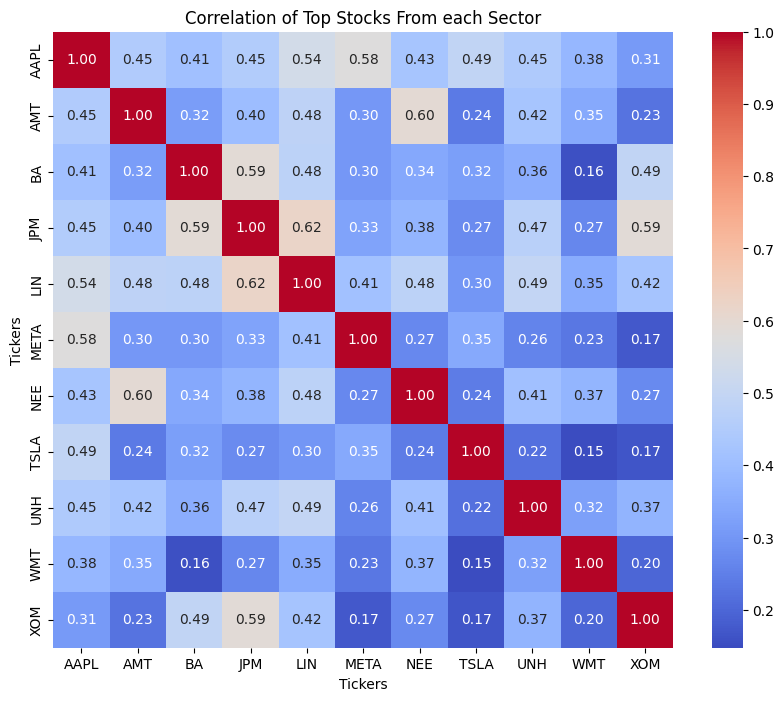

In [ ]:
# Compute the correlation matrix
correlation_matrix = pivot_df.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Top Stocks From each Sector')
plt.xlabel('Tickers')
plt.ylabel('Tickers')
plt.savefig('Heatmap.png')
plt.show()

In [ ]:
# Selecting the best stocks based on the correlation matrix manually
df = df.loc[df.index.get_level_values('Ticker').isin(['META', 'TSLA', 'WMT', 'XOM', 'UNH'])]
df = df.drop(columns=['Dollar Volume', 'Daily Returns'])
df = df.unstack()
adj_close = df['Adj Close']
# Resample data to business days,filling missing values with previous day
adj_close = adj_close[['META','TSLA','UNH','WMT','XOM']].asfreq('B').fillna(method='ffill')
adj_close.reset_index(inplace=True)
adj_close.head()

Ticker,Date,META,TSLA,UNH,WMT,XOM
0,2019-04-02,174.015366,19.058666,226.784027,29.794626,63.127239
1,2019-04-03,173.356064,19.454000,228.110886,29.871473,62.754910
2,2019-04-04,175.833435,17.851999,229.549103,30.154240,63.646969
3,2019-04-05,175.533752,18.330667,230.838852,30.375530,63.988266
4,2019-04-08,174.744583,18.213333,230.811020,30.498470,64.383881


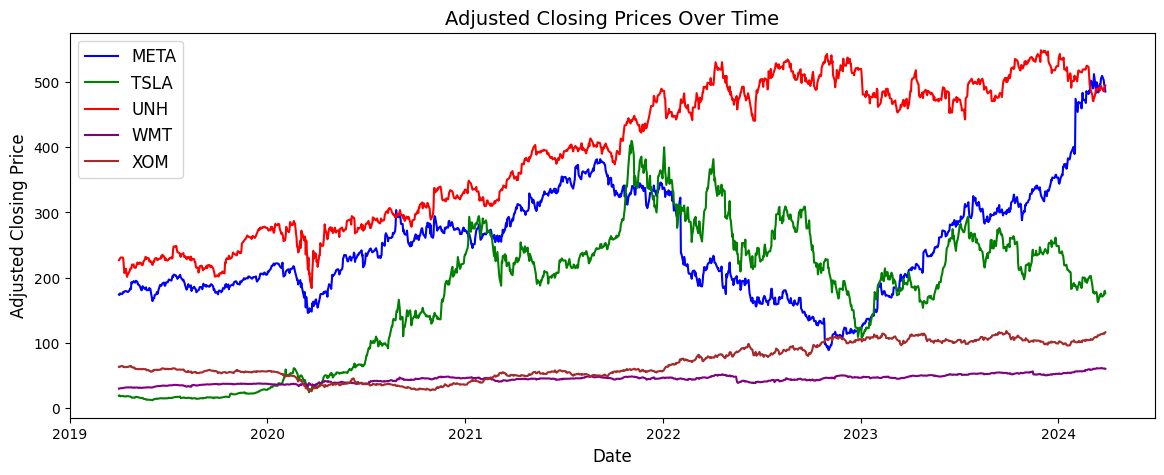

In [ ]:
# Plotting closing prices over time
plt.figure(figsize=(14, 5))
plt.plot(adj_close['Date'], adj_close['META'], label='META', color='blue')
plt.plot(adj_close['Date'], adj_close['TSLA'], label='TSLA', color='green')
plt.plot(adj_close['Date'], adj_close['UNH'], label='UNH', color='red')
plt.plot(adj_close['Date'], adj_close['WMT'], label='WMT', color='purple')
plt.plot(adj_close['Date'], adj_close['XOM'], label='XOM', color='brown')
plt.title('Adjusted Closing Prices Over Time',fontsize=14)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Adjusted Closing Price',fontsize=12)
plt.legend(fontsize=12)
plt.savefig('figure1.png')
plt.show()

In [ ]:
# Filter the DataFrame to include only data till 2024-02-10
selected_data = adj_close[adj_close['Date'] <= '2024-02-10']
selected_data.set_index('Date', inplace=True)

In [ ]:
selected_data.head()

Ticker,META,TSLA,UNH,WMT,XOM
Date,,,,,
2019-04-02,174.015366,19.058666,226.784027,29.794626,63.127239
2019-04-03,173.356064,19.454000,228.110886,29.871473,62.754910
2019-04-04,175.833435,17.851999,229.549103,30.154240,63.646969
2019-04-05,175.533752,18.330667,230.838852,30.375530,63.988266
2019-04-08,174.744583,18.213333,230.811020,30.498470,64.383881


In [ ]:
selected_data.describe()

Ticker,META,TSLA,UNH,WMT,XOM
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000
mean,243.042215,179.477000,389.640375,43.895593,68.987019
std,72.119720,104.272948,109.225944,5.949545,26.516990
min,88.815765,11.931333,183.959412,29.794626,25.646791
25%,186.072586,66.059998,282.787842,39.121155,49.962410
50%,232.533279,207.520004,400.464386,44.852177,58.594009
75%,303.248260,253.179993,488.162781,47.775345,98.960709
max,474.486542,409.970001,548.926025,56.411205,118.014030


In [ ]:
selected_data.reset_index(inplace=True)

In [ ]:
# Scaling data to a specified range using MinMaxScaler
def scale_data(data, feature_range=(0, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    return scaled_data, scaler

In [ ]:
# Splits scaled data into training and testing
def split_data(scaled_data, look_back=80, train_ratio=0.80, batch_size=20):
    train_size = int(len(scaled_data) * train_ratio)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - look_back:]

    train_generator = TimeseriesGenerator(train_data, train_data,
                                           length=look_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(test_data, test_data,
                                          length=look_back, batch_size=1)

    return train_generator, test_generator, test_data

In [ ]:
# Build LSTM model
def build_lstm_model(train_generator, epochs=100):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=100, return_sequences=True,
                        input_shape=(train_generator.length, 1)))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=100))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(train_generator, epochs=epochs)
    return lstm_model

In [ ]:

 # Build BI-LSTM model
def build_bi_lstm_model(train_generator, epochs = 100, look_back = 80):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(look_back, 1))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=epochs)
    return model


In [ ]:
# Build GRU model
def build_gru_model(train_generator, epochs=100, look_back=80):
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=epochs)
    return model


In [ ]:
# Generates predictions using the model and test generator
def generate_predictions(model, test_generator, scaler, test_data, look_back=80):
    predictions = model.predict(test_generator)
    predictions = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(test_data[look_back:])
    return predictions, actual_prices

In [ ]:
# Function to predict future
def predict_future_days(model, base_data, days_to_predict, scaler, look_back = 80):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

In [ ]:
# Visualizes the actual and predicted stock prices
def visualize_stock_prices(stock_name, actual_prices, predictions, font_size=12):
    plt.figure(figsize=(15, 5))
    plt.plot(actual_prices, color='red', label=f'{stock_name} Stock Price with LSTM')
    plt.plot(predictions, color='green', label=f'Predicted {stock_name} Stock Price with LSTM')
    plt.title(f'{stock_name} Stock Price Prediction',fontsize=font_size + 2)
    plt.xlabel('Time',fontsize=font_size)
    plt.ylabel(f'{stock_name} Stock Price',fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)
    plt.savefig(f'{stock_name}figure Prediction.png')
    plt.show()

In [ ]:
# Plots historical and predicted future stock prices
def plot_stock_price_prediction(stock_name, adj_close, selected_data, days_to_predict, future_days, font_size=12):
    last_date = selected_data['Date'].iloc[-1]
    predicted_dates = pd.date_range(start=last_date, periods=days_to_predict)
    plt.figure(figsize=(15, 5))
    plt.plot(adj_close['Date'], adj_close[stock_name], color='blue', label=f'Historical Daily Closing Price of {stock_name}')
    plt.plot(predicted_dates, future_days, color='red', label=f'Predicted Future Price of {stock_name} for the Next {days_to_predict} Days', linestyle='dashed')
    plt.title(f'{stock_name} Stock Price Prediction for the Next {days_to_predict} Days',fontsize=font_size + 2)
    plt.xlabel('Time',fontsize=font_size)
    plt.ylabel(f'{stock_name} Stock Price',fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)
    plt.savefig(f'{stock_name}_Future_Prediction.png')
    plt.show()

In [ ]:
days_to_predict = 90
# Top 5 S&P 500 stocks
top_tickers = ['META','TSLA','UNH','WMT','XOM']

Epoch 1/100
47/47 [==============================] - 7s 15ms/step - loss: 0.0178
Epoch 2/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0039
Epoch 3/100
47/47 [==============================] - 1s 17ms/step - loss: 0.0034
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 0.0034
Epoch 5/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 6/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 8/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0033
Epoch 9/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0043
Epoch 10/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 11/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 12/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 13/100
47/47 [=====

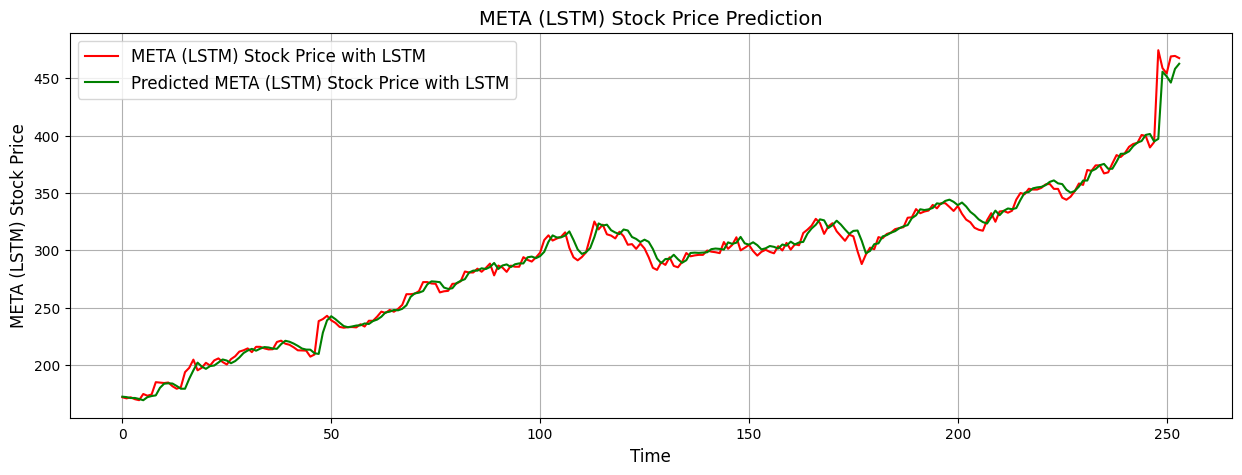

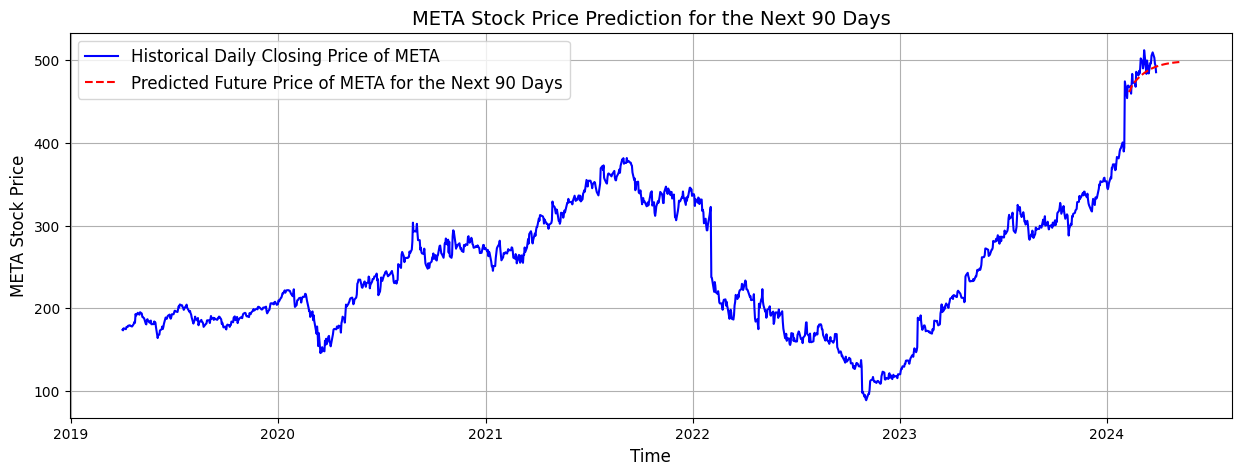

In [ ]:
# Process and evaluate LSTM predictions for a list of stocks
for stock_name in top_tickers:

    lstm_start_time = time.time()

    # Assuming y and scaler are properly initialized
    y, scaler = scale_data(selected_data[stock_name])
    train_generator, test_generator, test_data = split_data(y)

    # Build LSTM model
    lstm_model = build_lstm_model(train_generator)

    # End time
    lstm_end_time = time.time()

    # Generate LSTM predictions
    lstm_predictions, lstm_actual_prices = generate_predictions(lstm_model, test_generator, scaler, test_data)

    # Predict future days
    future_days_lstm = predict_future_days(lstm_model, y, days_to_predict, scaler,look_back = 80)


    # Calculate time taken
    lstm_training_time = lstm_end_time - lstm_start_time

    # Calculate evaluation metrics
    lstm_rmse = np.sqrt(mean_squared_error(lstm_actual_prices, lstm_predictions))
    lstm_mae = mean_absolute_error(lstm_actual_prices, lstm_predictions)

    print(f"Stock: {stock_name} (LSTM) ")
    print(f"Training Time: {lstm_training_time} seconds")
    print(f"RMSE: {lstm_rmse}")
    print(f"MAE: {lstm_mae}")

    # Visualize results for LSTM model
    visualize_stock_prices(f'{stock_name} (LSTM)', lstm_actual_prices, lstm_predictions)

    plot_stock_price_prediction(f'{stock_name}', adj_close, selected_data, days_to_predict, future_days_lstm)



Epoch 1/100
47/47 [==============================] - 8s 16ms/step - loss: 0.0250
Epoch 2/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0071
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0051
Epoch 4/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0056
Epoch 5/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0067
Epoch 6/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0085
Epoch 7/100
47/47 [==============================] - 1s 18ms/step - loss: 0.0063
Epoch 8/100
47/47 [==============================] - 1s 19ms/step - loss: 0.0044
Epoch 9/100
47/47 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 10/100
47/47 [==============================] - 1s 24ms/step - loss: 0.0030
Epoch 11/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0052
Epoch 12/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0032
Epoch 13/100
47/47 [=====

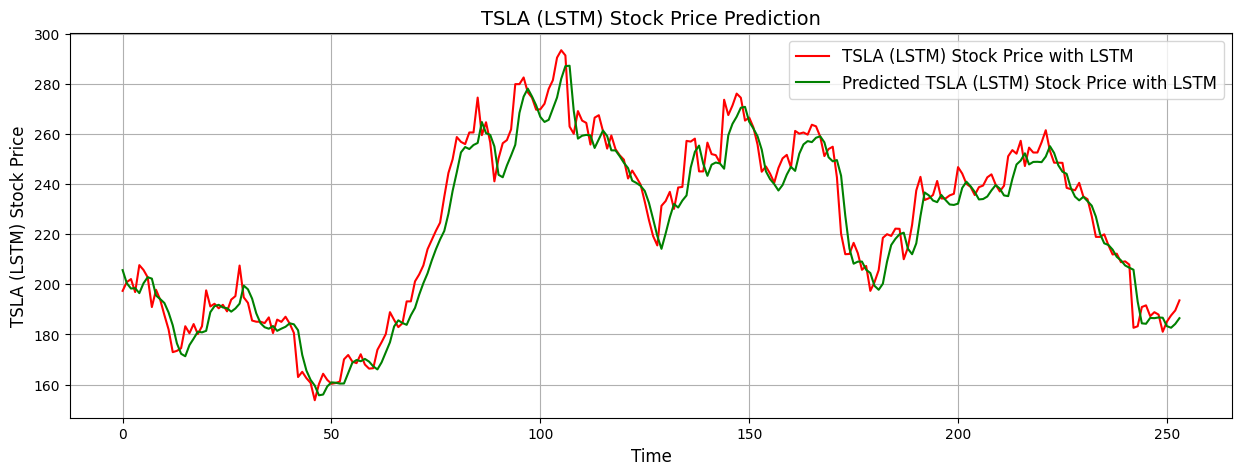

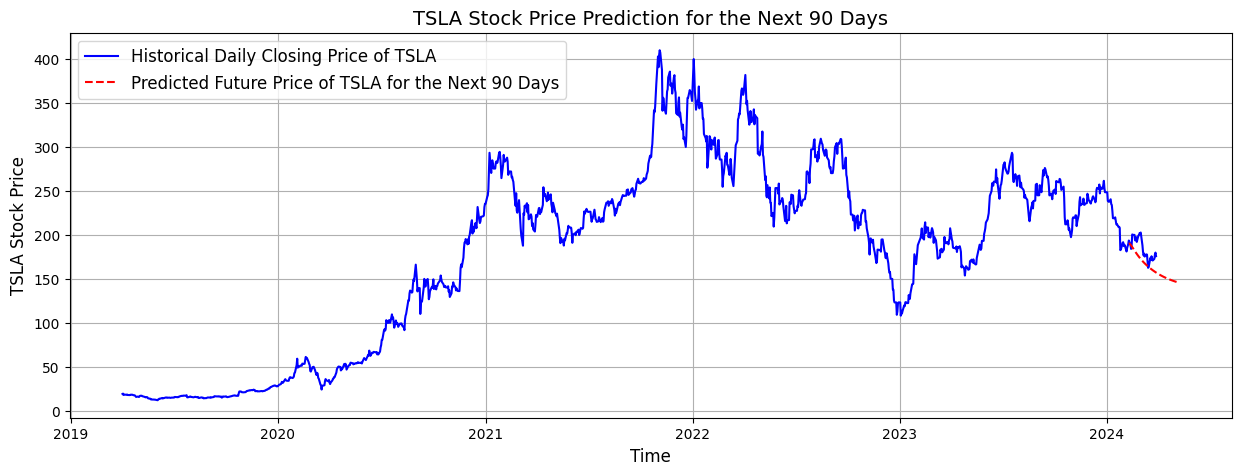

Epoch 1/100
47/47 [==============================] - 6s 14ms/step - loss: 0.0179
Epoch 2/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0051
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0155
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0109
Epoch 7/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 8/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0038
Epoch 9/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 10/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 11/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 12/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0046
Epoch 13/100
47/47 [=====

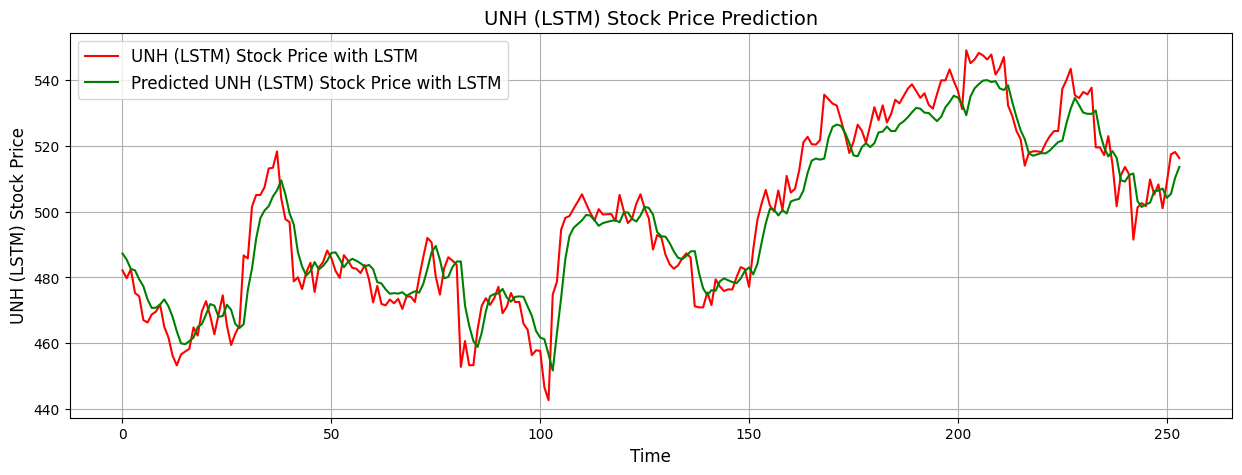

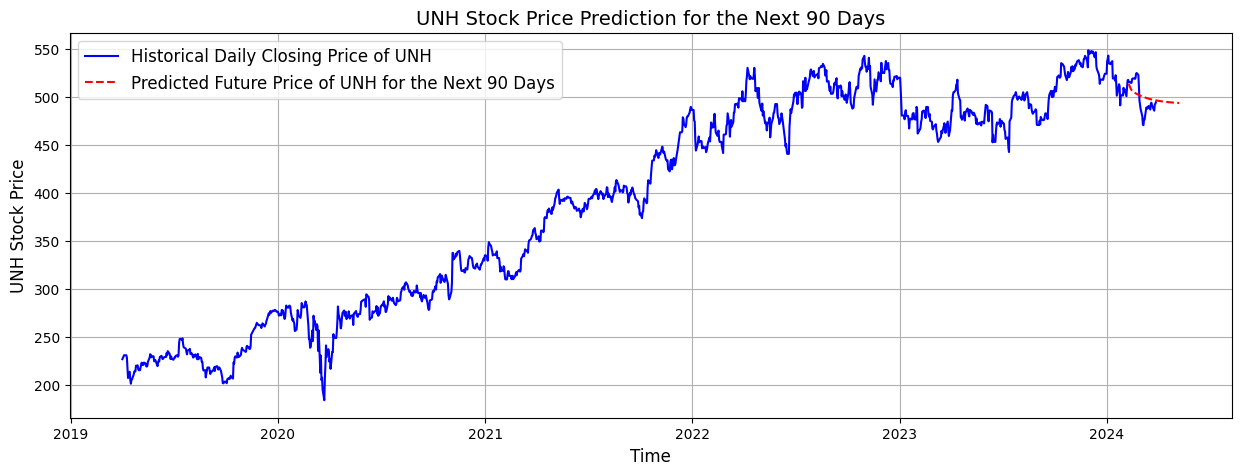

Epoch 1/100
47/47 [==============================] - 6s 14ms/step - loss: 0.0183
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0072
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0116
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0075
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0069
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0049
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0039
Epoch 10/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 11/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 12/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 13/100
47/47 [=====

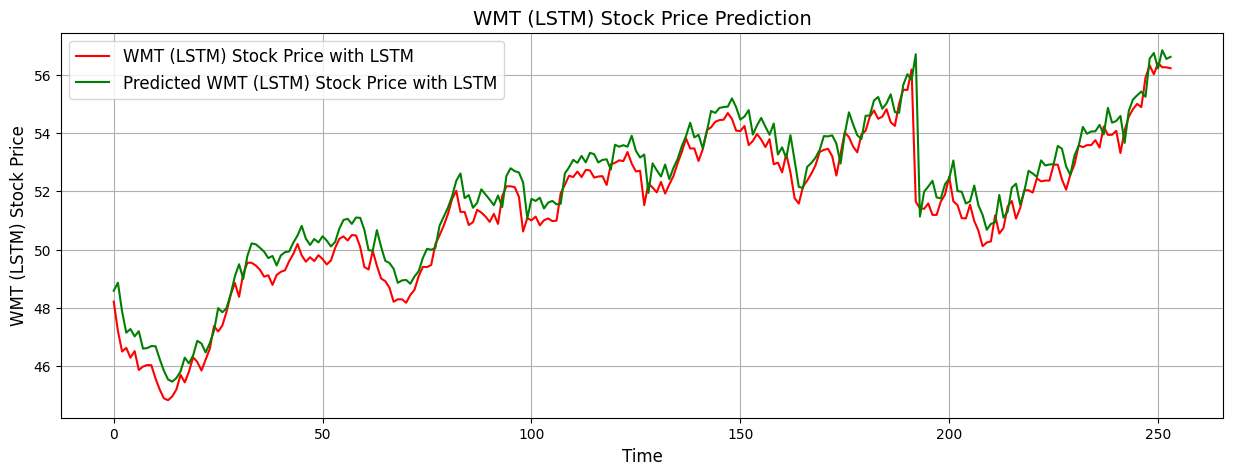

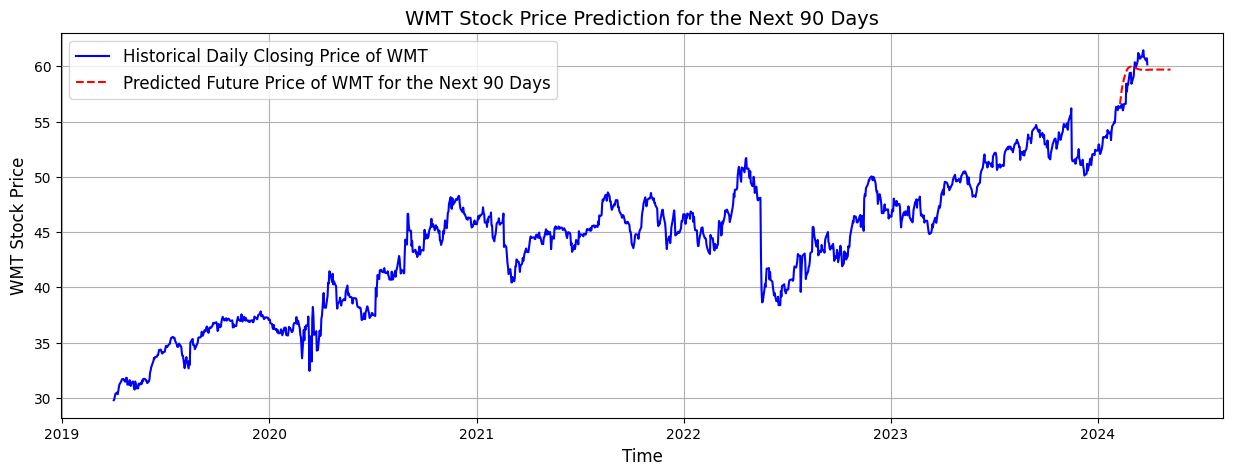

Epoch 1/100
47/47 [==============================] - 6s 14ms/step - loss: 0.0077
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0106
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0076
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0038
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 7/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 8/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 9/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 10/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 11/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 12/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0021
Epoch 13/100
47/47 [=====

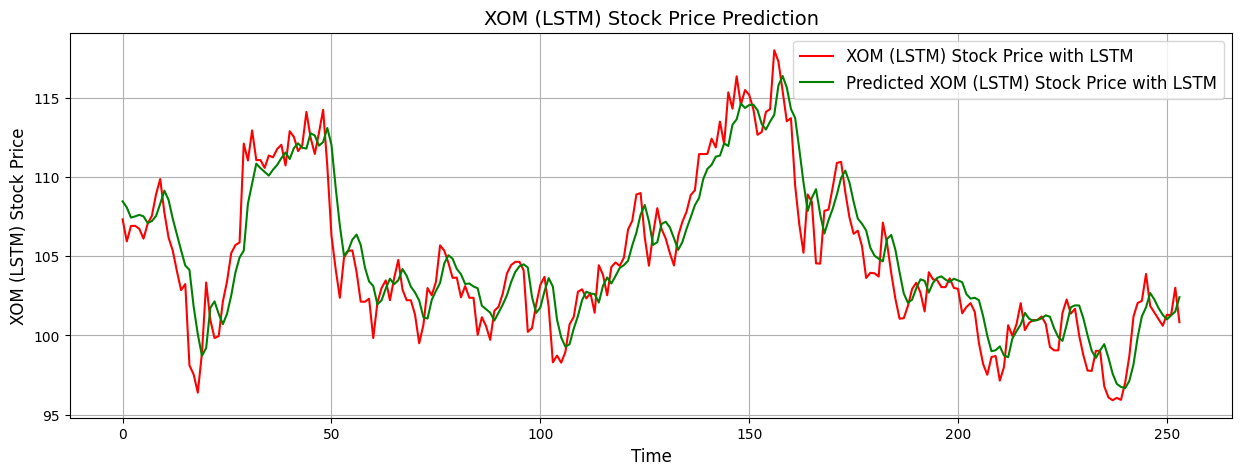

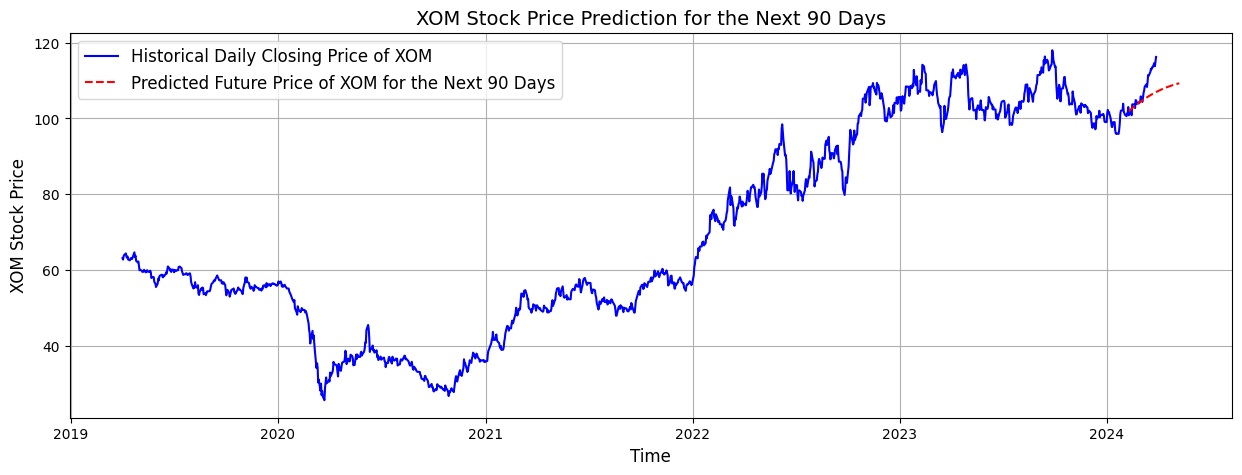

**Bi-LSTM**

Epoch 1/100
47/47 [==============================] - 14s 25ms/step - loss: 0.0147
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0051
Epoch 3/100
47/47 [==============================] - 1s 28ms/step - loss: 0.0030
Epoch 4/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0040
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0031
Epoch 7/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0022
Epoch 8/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0027
Epoch 9/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0024
Epoch 10/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0027
Epoch 11/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0037
Epoch 12/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0026
Epoch 13/100
47/47 [====

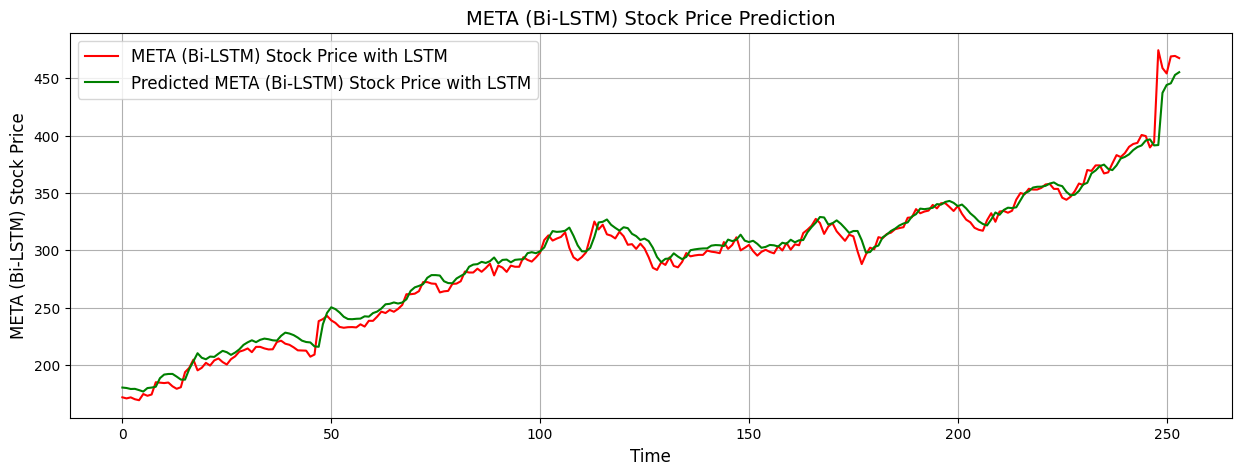

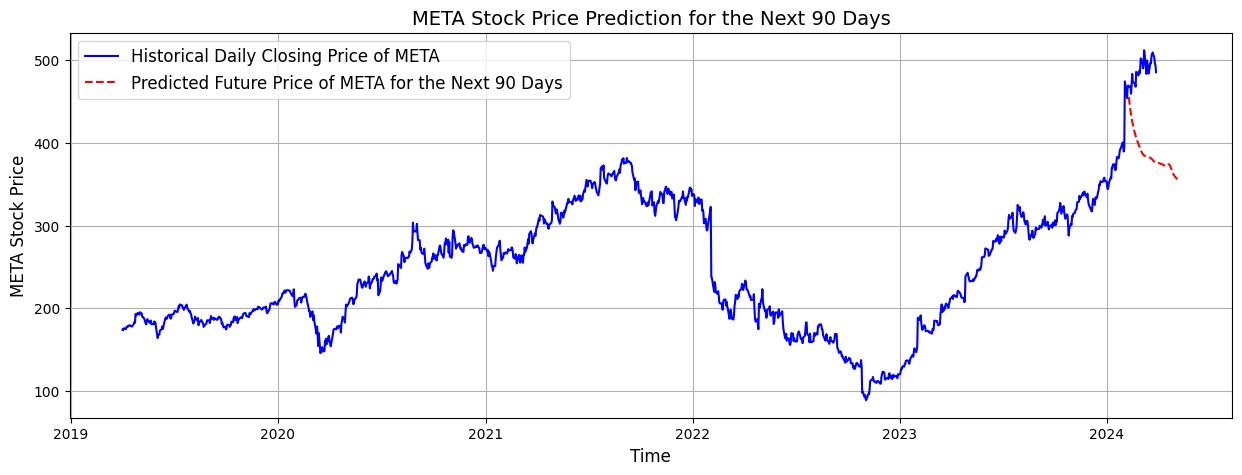

In [ ]:
# Process and evaluate Bi-LSTM predictions for a list of stocks
for stock_name in top_tickers:

    bi_lstm_start_time = time.time()

    # Assuming y and scaler are properly initialized
    y, scaler = scale_data(selected_data[stock_name])
    train_generator, test_generator, test_data = split_data(y)

    # Build Bi-LSTM model
    bi_lstm_model = build_bi_lstm_model(train_generator)

    # End time
    bi_lstm_end_time = time.time()

    # Generate Bi-LSTM predictions
    bi_lstm_predictions, bi_lstm_actual_prices = generate_predictions(bi_lstm_model, test_generator, scaler, test_data)

    # Predict future days
    future_days_bi_lstm = predict_future_days(bi_lstm_model, y, days_to_predict, scaler, look_back = 80)

    # Calculate time taken
    bi_lstm_training_time = bi_lstm_end_time - bi_lstm_start_time

    # Calculate evaluation metrics
    bi_lstm_rmse = np.sqrt(mean_squared_error(bi_lstm_actual_prices, bi_lstm_predictions))
    bi_lstm_mae = mean_absolute_error(bi_lstm_actual_prices, bi_lstm_predictions)

    print(f"Stock: {stock_name} (Bi-LSTM) ")
    print(f"Training Time: {bi_lstm_training_time} seconds")
    print(f"RMSE: {bi_lstm_rmse}")
    print(f"MAE: {bi_lstm_mae}")

    # Visualize results for Bi-LSTM model
    visualize_stock_prices(f'{stock_name} (Bi-LSTM)', bi_lstm_actual_prices, bi_lstm_predictions)

    plot_stock_price_prediction(f'{stock_name}', adj_close, selected_data, days_to_predict, future_days_bi_lstm)


Epoch 1/100
47/47 [==============================] - 12s 24ms/step - loss: 0.0370
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0070
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0100
Epoch 4/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0048
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0033
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0036
Epoch 7/100
47/47 [==============================] - 2s 35ms/step - loss: 0.0078
Epoch 8/100
47/47 [==============================] - 1s 31ms/step - loss: 0.0035
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0031
Epoch 10/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0037
Epoch 11/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0042
Epoch 12/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0023
Epoch 13/100
47/47 [====

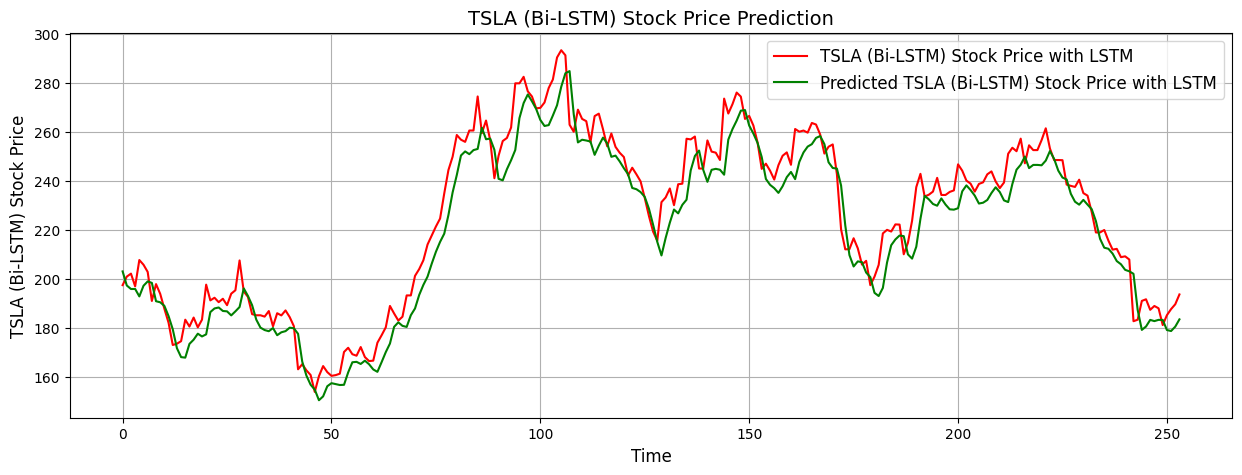

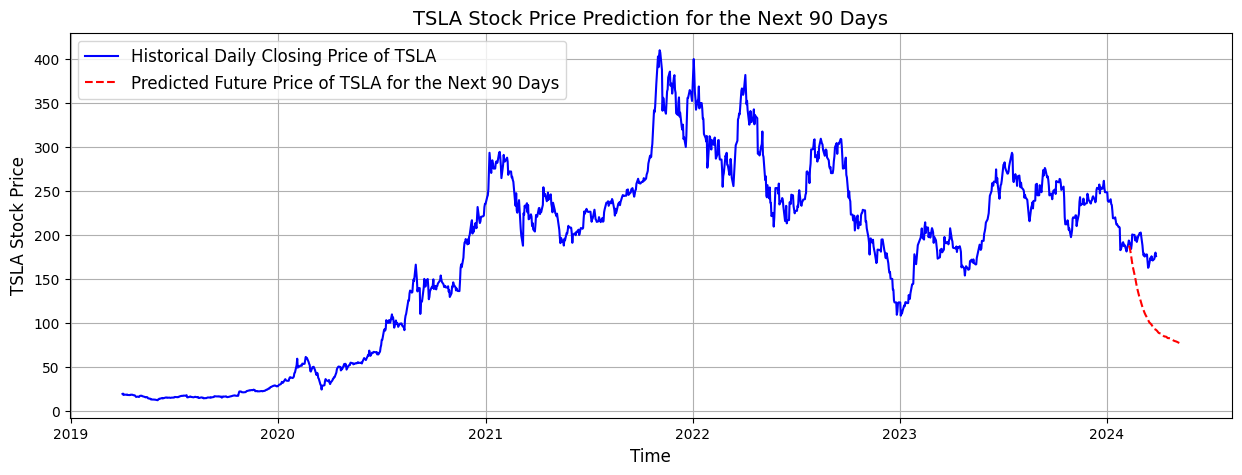

Epoch 1/100
47/47 [==============================] - 14s 25ms/step - loss: 0.0321
Epoch 2/100
47/47 [==============================] - 1s 28ms/step - loss: 0.0068
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0041
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0032
Epoch 5/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0037
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 7/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0035
Epoch 8/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0027
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0056
Epoch 10/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0036
Epoch 11/100
47/47 [==============================] - 1s 24ms/step - loss: 0.0031
Epoch 12/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0028
Epoch 13/100
47/47 [====

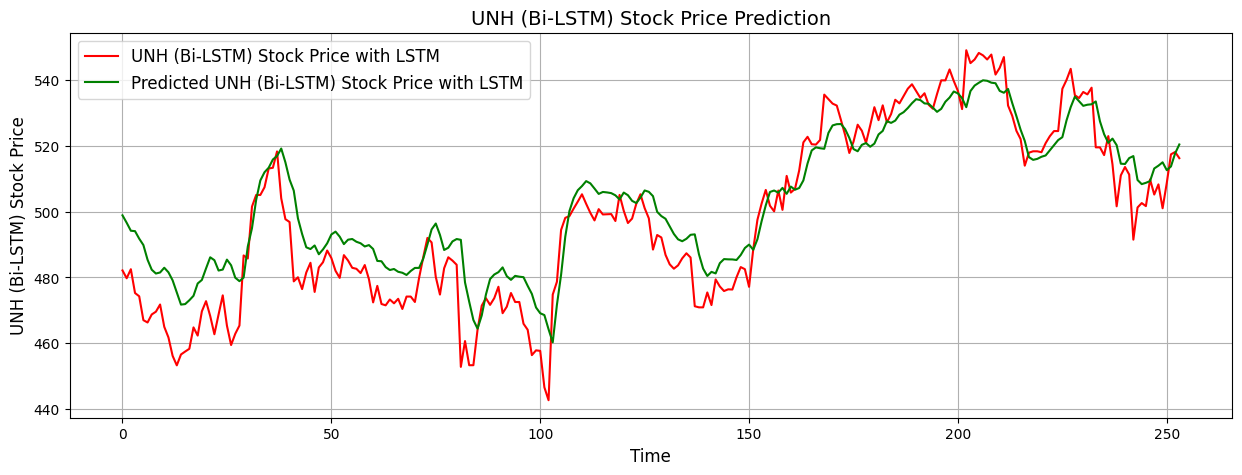

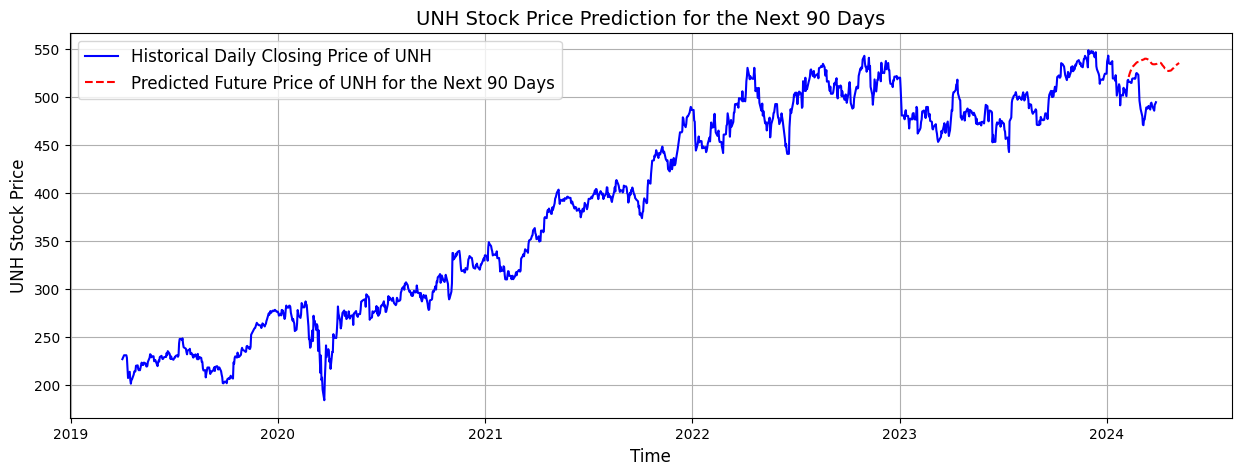

Epoch 1/100
47/47 [==============================] - 12s 24ms/step - loss: 0.0203
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0082
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0056
Epoch 4/100
47/47 [==============================] - 1s 28ms/step - loss: 0.0042
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0035
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0032
Epoch 7/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0029
Epoch 8/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 9/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0035
Epoch 10/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0027
Epoch 11/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0025
Epoch 12/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0036
Epoch 13/100
47/47 [====

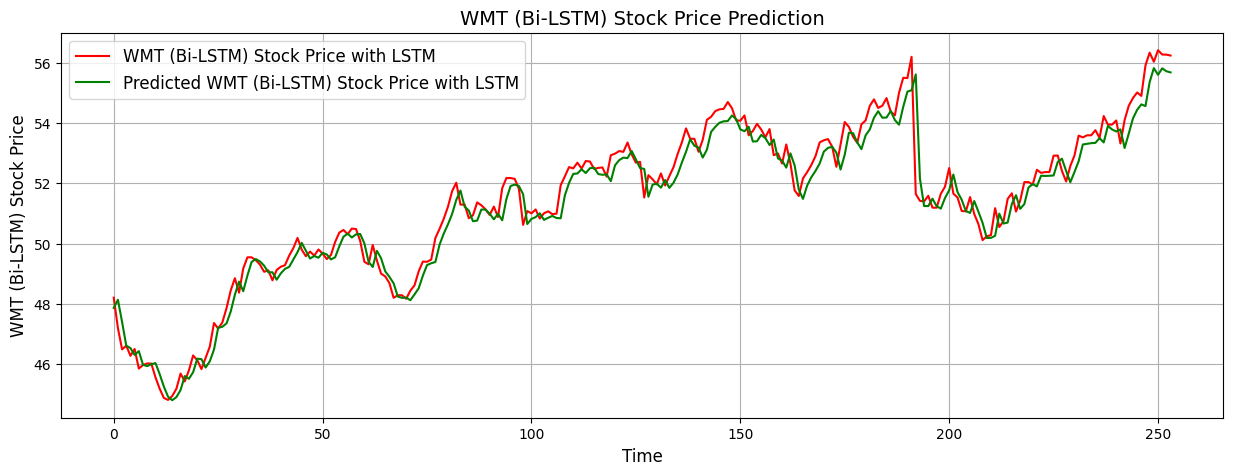

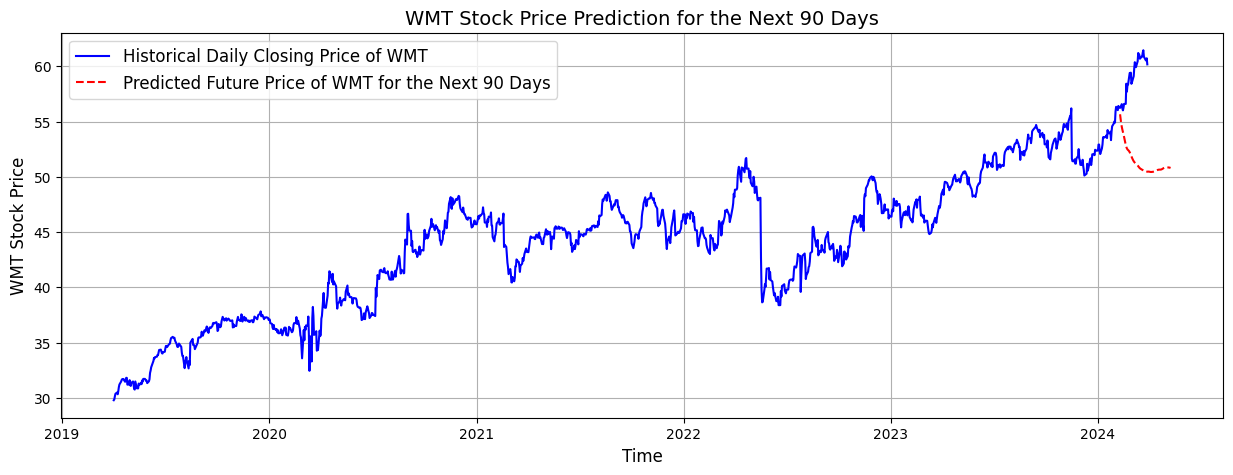

Epoch 1/100
47/47 [==============================] - 12s 29ms/step - loss: 0.0174
Epoch 2/100
47/47 [==============================] - 1s 26ms/step - loss: 0.0042
Epoch 3/100
47/47 [==============================] - 1s 24ms/step - loss: 0.0028
Epoch 4/100
47/47 [==============================] - 1s 26ms/step - loss: 0.0029
Epoch 5/100
47/47 [==============================] - 1s 25ms/step - loss: 0.0020
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0021
Epoch 7/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0033
Epoch 8/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0037
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0024
Epoch 10/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 11/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 12/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 13/100
47/47 [====

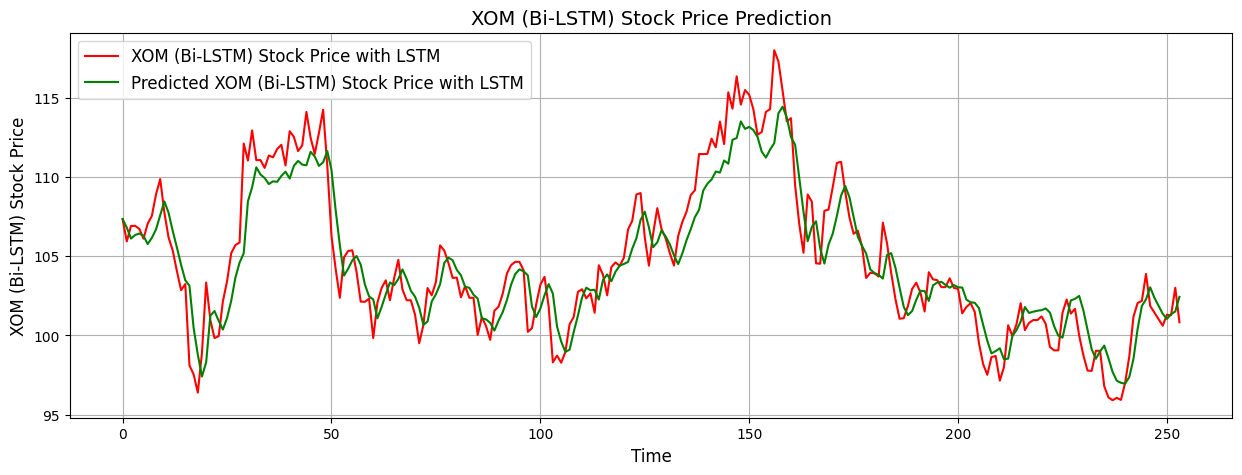

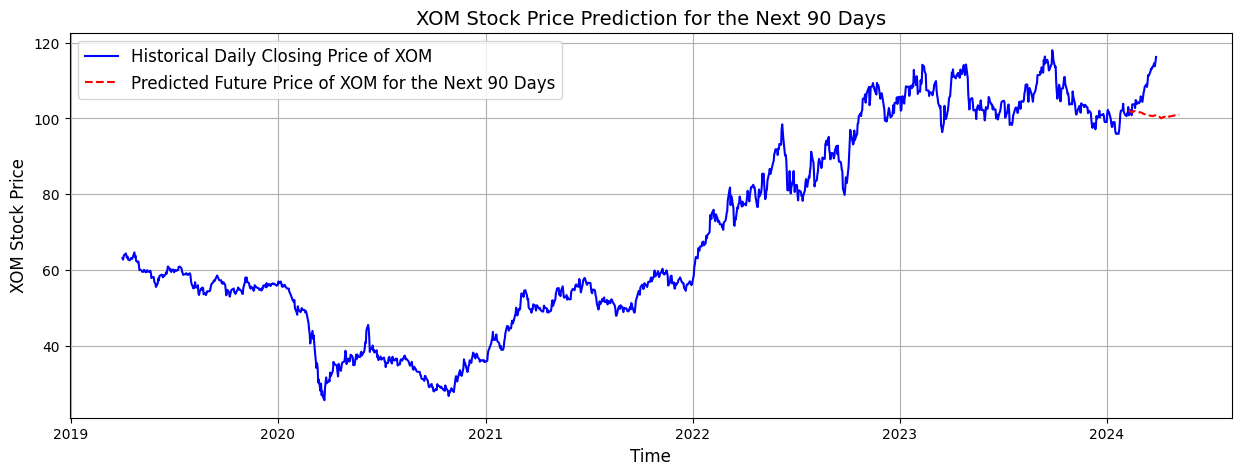

**GRU Model**

Epoch 1/100
47/47 [==============================] - 6s 14ms/step - loss: 0.0111
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0019
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0021
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 6/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0024
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 10/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 11/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 12/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 13/100
47/47 [=====

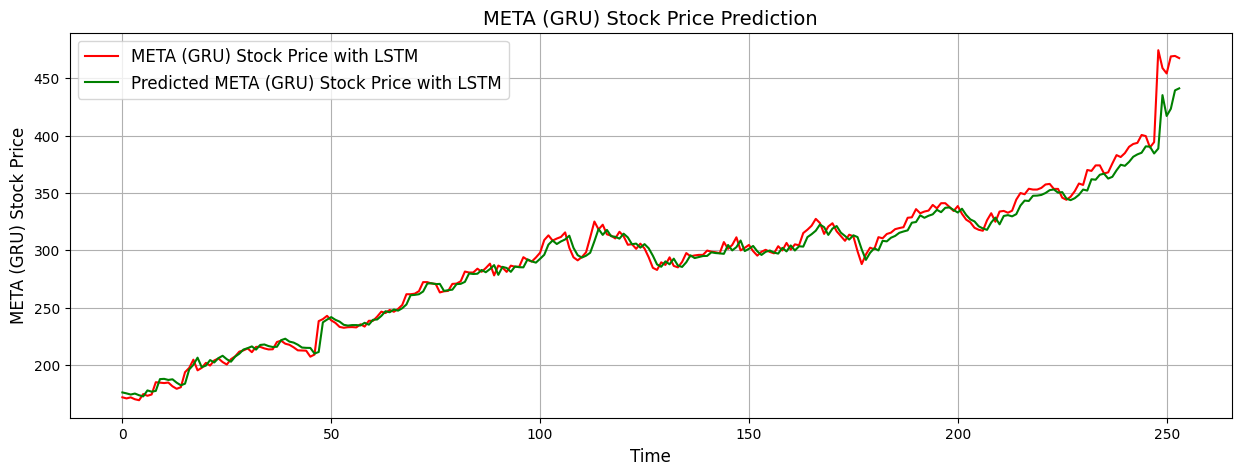

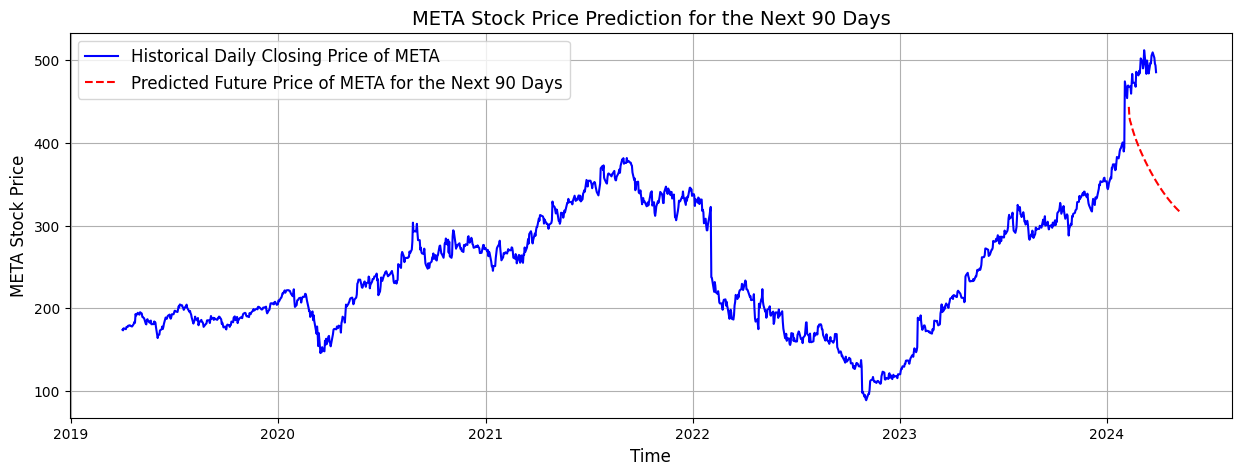

In [ ]:
# Process and evaluate GRU predictions for a list of stocks
for stock_name in top_tickers:

    gru_start_time = time.time()

    # Assuming y and scaler are properly initialized
    y, scaler = scale_data(selected_data[stock_name])
    train_generator, test_generator, test_data = split_data(y)

    # Build GRU model
    gru_model = build_gru_model(train_generator)

    # End time
    gru_end_time = time.time()

    # Generate GRU predictions
    gru_predictions, gru_actual_prices = generate_predictions(gru_model, test_generator, scaler, test_data)

    # Predict future days
    future_days_gru = predict_future_days(gru_model, y, days_to_predict, scaler, look_back = 80)

    # Calculate time taken
    gru_training_time = gru_end_time - gru_start_time

    # Calculate evaluation metrics
    gru_rmse = np.sqrt(mean_squared_error(gru_actual_prices, gru_predictions))
    gru_mae = mean_absolute_error(gru_actual_prices, gru_predictions)

    print(f"Stock: {stock_name} (GRU) ")
    print(f"Training Time: {gru_training_time} seconds")
    print(f"RMSE: {gru_rmse}")
    print(f"MAE: {gru_mae}")

    # Visualize results for GRU model
    visualize_stock_prices(f'{stock_name} (GRU)', gru_actual_prices, gru_predictions)

    plot_stock_price_prediction(f'{stock_name}', adj_close, selected_data, days_to_predict, future_days_gru)


Epoch 1/100
47/47 [==============================] - 5s 14ms/step - loss: 0.0273
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0038
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0029
Epoch 8/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 10/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0039
Epoch 11/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 12/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0035
Epoch 13/100
47/47 [=====

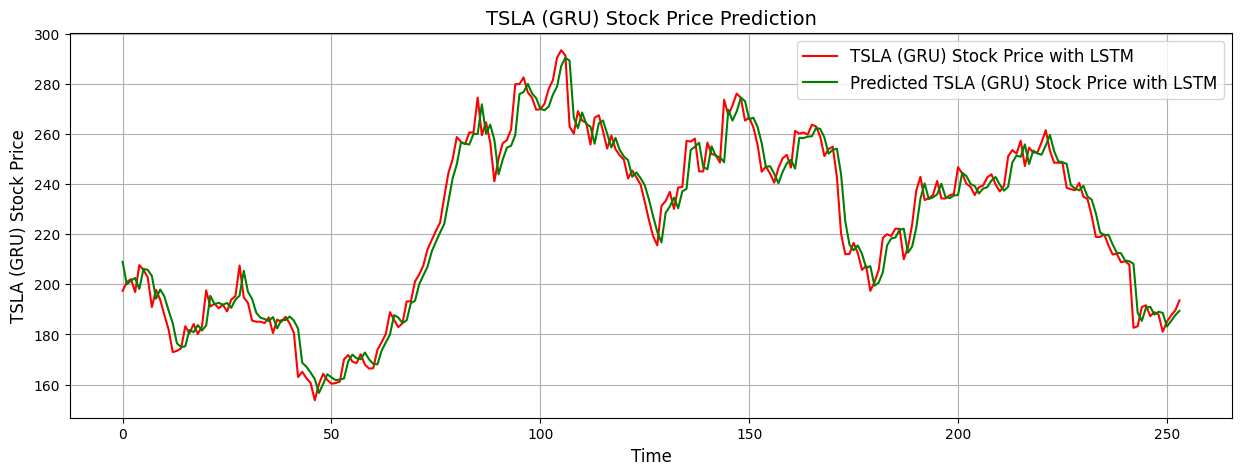

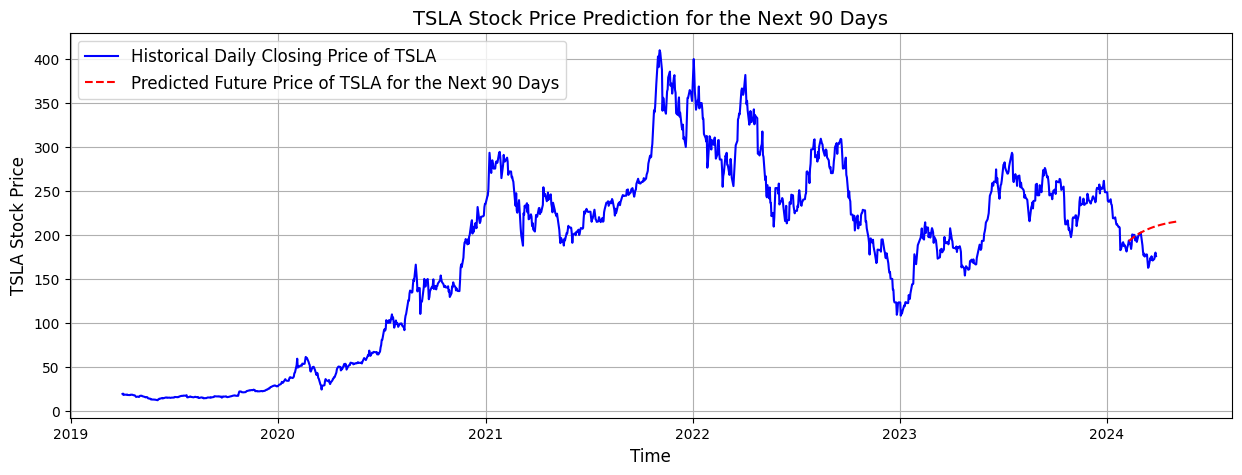

Epoch 1/100
47/47 [==============================] - 5s 16ms/step - loss: 0.0247
Epoch 2/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0039
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0032
Epoch 6/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0034
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0053
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 10/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0028
Epoch 11/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 12/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 13/100
47/47 [=====

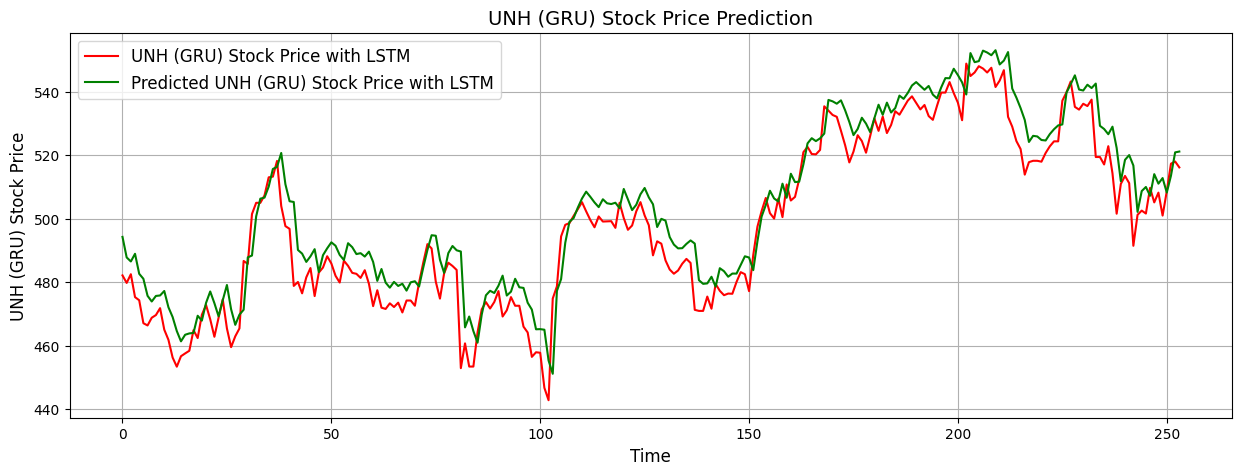

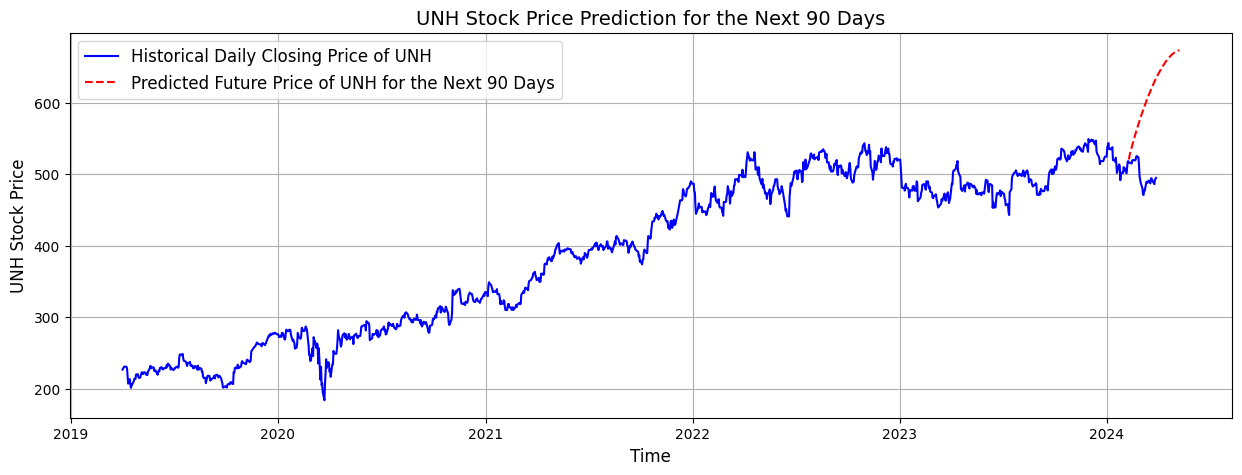

Epoch 1/100
47/47 [==============================] - 6s 13ms/step - loss: 0.0221
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0035
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0050
Epoch 6/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 8/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 9/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0028
Epoch 10/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0027
Epoch 11/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 12/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 13/100
47/47 [=====

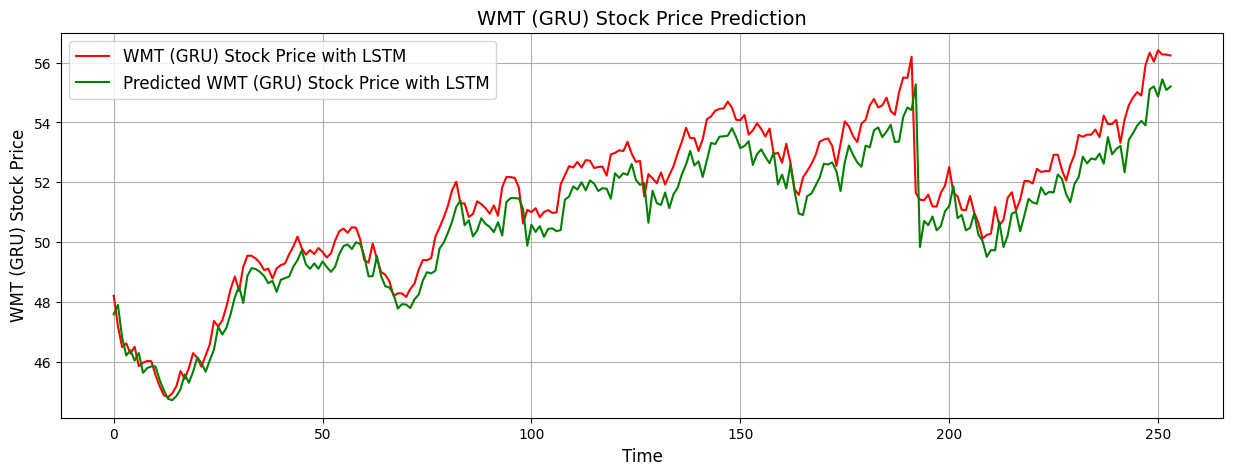

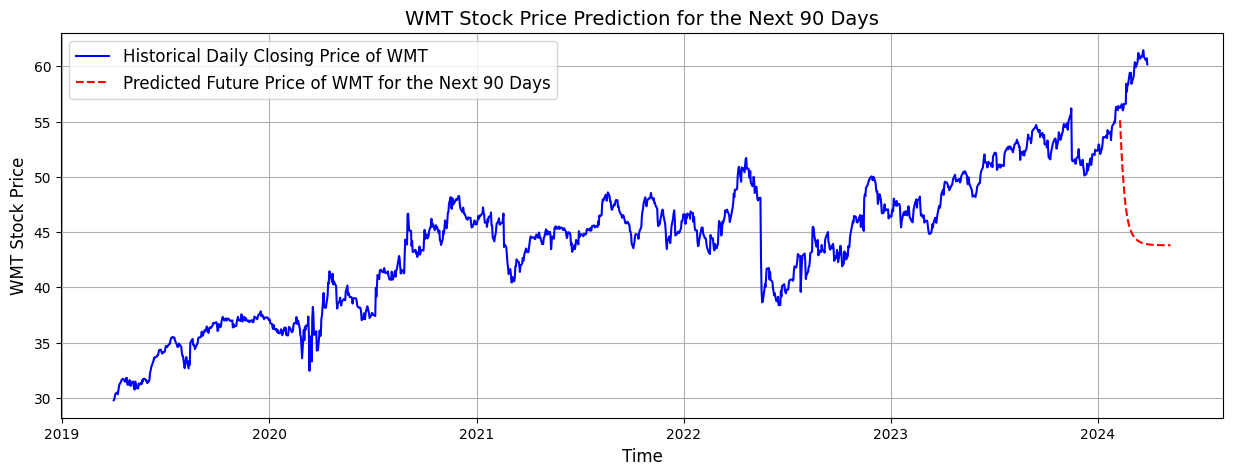

Epoch 1/100
47/47 [==============================] - 6s 14ms/step - loss: 0.0273
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 6/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0045
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0037
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0020
Epoch 10/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 11/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 12/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 13/100
47/47 [=====

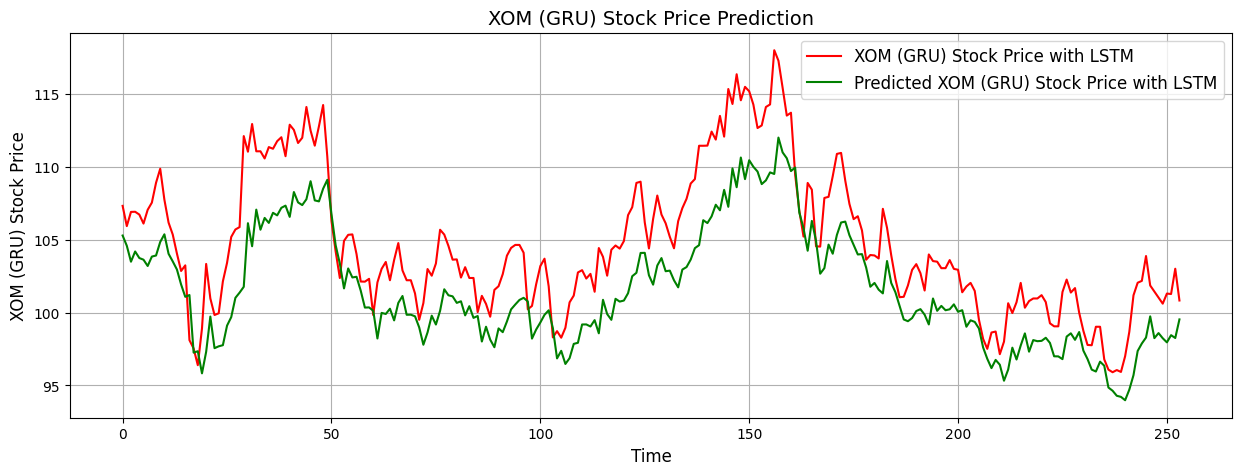

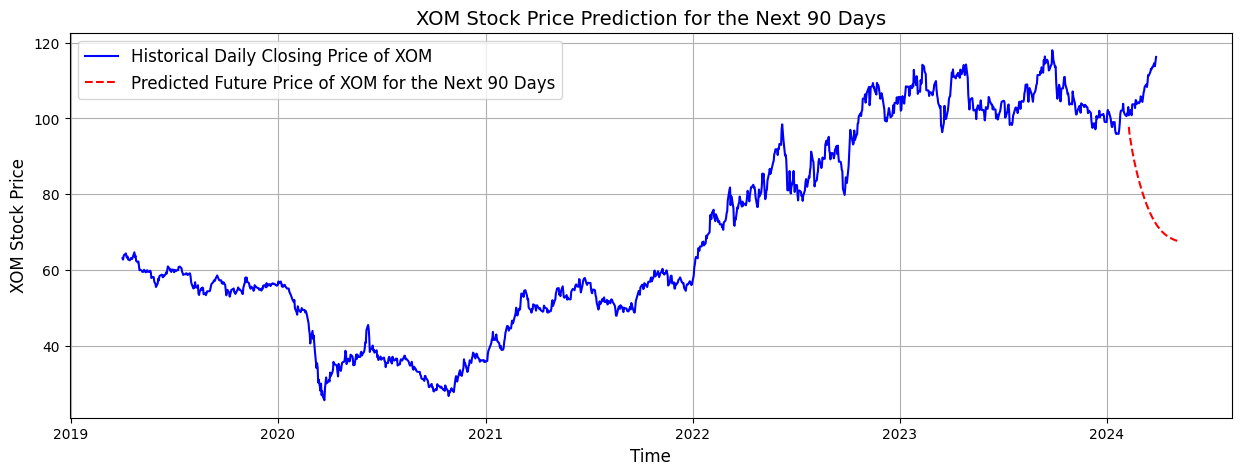